# FIGURE 2

In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.cross_decomposition import PLSRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from msresist.parameter_tuning import kmeansPLSR_tuning
from msresist.figures.figure2 import plotR2YQ2Y, plotKmeansPLSR_GridSearch, plotMeasuredVsPredicted, plotScoresLoadings, plotclusteraverages
from msresist.plsr import Q2Y_across_components, R2Y_across_components
from msresist.clustering import MyOwnKMEANS
from msresist.sequence_analysis import preprocess_seqs
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from msresist.pre_processing import preprocessing, MergeDfbyMean
from msresist.FileExporter import create_download_link
import warnings
warnings.simplefilter("ignore")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.mixture.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.mixture. Anything that cannot be imported from sklearn.mixture is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



### Importing and Pre-processing Data

### Phosphorylation measurements:

In [2]:
# pd.set_option('display.max_colwidth', 1000)
# pd.set_option('display.max_rows', 1000)

ABC = preprocessing(AXLwt=True, motifs=True, Vfilter=True, FCfilter=False, log2T=True, mc_row=True)
ABC = preprocess_seqs(ABC, "Y").sort_values(by="Protein")


header = ABC.columns
treatments = ABC.columns[7:]

data = ABC.iloc[:, 7:].T

In [3]:
data

,0,2,3,4,6,7,8,9,11,10,...,722,723,724,725,726,728,730,731,732,734
PC9,0.891610,0.136615,0.413272,2.028584,0.398969,-0.297124,0.172706,-0.117404,-0.247217,0.409301,...,0.101719,-0.210772,0.315260,-0.288012,-0.199057,2.169358,1.316789,2.694753,0.577963,1.305788
Erl,-0.132290,-0.096407,0.620284,1.620221,-0.087536,-0.005490,0.015600,0.026626,-0.354743,0.263841,...,0.001506,-1.350055,0.145629,-0.256027,0.454706,1.570918,0.388504,0.852521,0.026361,-0.140178
R428,0.508638,0.066187,0.352508,1.301309,-0.026767,0.116918,0.179464,-0.220300,-0.141233,0.234600,...,-0.144408,-0.560998,0.066405,-0.225507,0.653321,0.620437,0.263724,0.959014,0.046690,0.560394
Erl/R428,-0.431225,-0.318742,-0.291815,-0.568873,-0.242677,-0.041076,-0.046343,-0.024090,0.133679,0.007094,...,-0.086224,0.065785,-0.287281,-0.122223,0.118713,-1.374179,-1.455803,-1.434426,0.203022,-0.341179
Erl+HGF,-0.008149,-0.249576,0.122734,-0.712916,0.073363,-0.157658,-0.086309,-0.291813,0.097310,-0.063472,...,0.238026,-0.264265,0.033551,0.109054,0.350850,0.289226,0.597152,0.582779,0.399508,-0.250761
Erl+FGF,0.338497,0.048889,0.216532,-0.731959,0.102959,-0.186365,0.093422,-0.245455,0.090287,0.049989,...,0.059869,-0.583999,0.069366,0.135095,-0.040757,-0.012489,0.022433,-0.266371,0.017095,-0.073179
Erl+IGF,-0.481326,-0.209506,0.167650,-0.791261,-0.013749,-0.035143,0.046119,-0.155121,0.314129,-0.064102,...,0.603850,1.222372,0.023668,0.092834,-0.211529,0.232086,0.432893,-0.040972,-0.176009,-0.065153
KO Erl,-0.713501,0.095823,-0.586405,-0.762381,-0.281104,0.390447,-0.167274,0.066389,0.024115,-0.432393,...,-0.504786,0.066240,-0.109561,0.208458,-0.172431,-0.981527,-0.449084,-1.194264,-0.181494,-0.676516
KO R428,0.547278,0.241643,-0.395571,-0.574292,0.020479,0.482194,-0.117651,0.469875,0.024195,-0.172979,...,-0.096500,1.714528,-0.048382,0.195376,0.132210,-1.024902,-0.012254,-0.760311,-0.215097,0.236585
KO Erl/R428,-0.519532,0.285073,-0.619189,-0.808433,0.056064,-0.266704,-0.089734,0.491293,0.059478,-0.231880,...,-0.173054,-0.098834,-0.208655,0.150952,-1.086025,-1.488927,-1.104353,-1.392723,-0.698038,-0.555803


### Phenotypes

#### Cell Viability:

In [4]:
Y_cv1 = pd.read_csv('./msresist/data/Phenotypic_data/GrowthFactors/CV_raw3.csv').iloc[:30, :11]
Y_cv2 = pd.read_csv('./msresist/data/Phenotypic_data/GrowthFactors/CV_raw4.csv').iloc[:29, :11]

for ii in range(1, Y_cv2.columns.size):
    Y_cv1.iloc[:, ii] /= Y_cv1.iloc[0, ii]
    Y_cv2.iloc[:, ii] /= Y_cv2.iloc[0, ii]

Y_cv = MergeDfbyMean(pd.concat([Y_cv1, Y_cv2], axis=0), Y_cv1.columns, "Elapsed")
Y_cv = Y_cv.reset_index()[Y_cv1.columns]
Y_cv = Y_cv[Y_cv["Elapsed"] == 72].iloc[0, 1:]

## 1. Cross-validation

### 1.1 Strategy 1: R2Y/Q2Y after k-means clustering (k=5)

Cross-validation fitting averages of k-means clusters into the PLSR model. Number of clusters must be set in advance:

In [5]:
ncl = 2

In [6]:
kmeans = MyOwnKMEANS(ncl).fit(data, Y_cv)
centers = kmeans.transform(data)

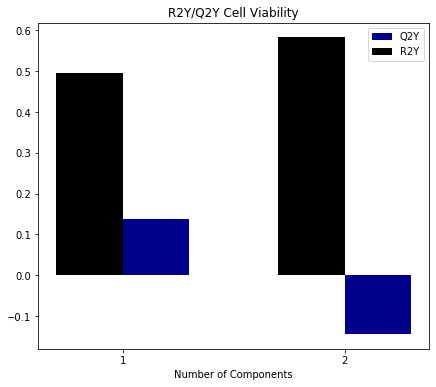

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(7,6))
plotR2YQ2Y(ax, centers, Y_cv)

### 1.2 Strategy 2: Gridsearch

Cross-validation fitting averages of k-means clusters into the PLSR model. Simulatenous tuning of number of clusters and number of components using GridSearch:

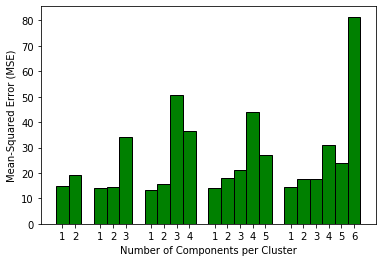

In [8]:
fig, ax = plt.subplots(1, 1)
plotKmeansPLSR_GridSearch(ax, data, Y_cv)

## 2. Model Predicted vs Actual for best Hyperparameter Set

In [9]:
ncomp = 2

### 2.1 With CV Strategy 1:

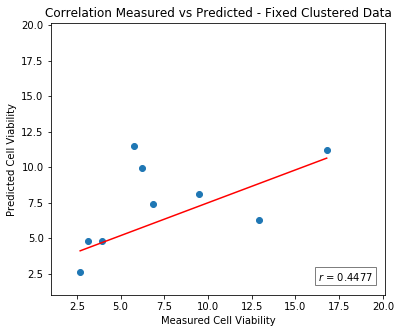

In [10]:
fig, ax = plt.subplots(1,1,figsize=(6,5))

plotMeasuredVsPredicted(ax, PLSRegression(ncomp), centers, Y_cv)
plt.title("Correlation Measured vs Predicted - Fixed Clustered Data");

### 2.2 With CV Strategy 2:

In [11]:
estimators = [('kmeans', MyOwnKMEANS(ncl)), ('plsr', PLSRegression(ncomp))]
kmeans_plsr = Pipeline(estimators)
fit = kmeans_plsr.fit(data, Y_cv)
centers_ab = kmeans_plsr.named_steps.kmeans.transform(data)

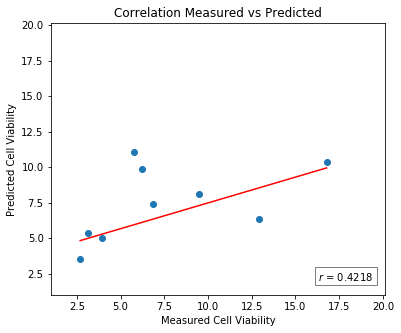

In [12]:
fig, ax = plt.subplots(1,1,figsize=(6,5))
plotMeasuredVsPredicted(ax, kmeans_plsr, data, Y_cv)

## 3. PLSR scores and loadings 

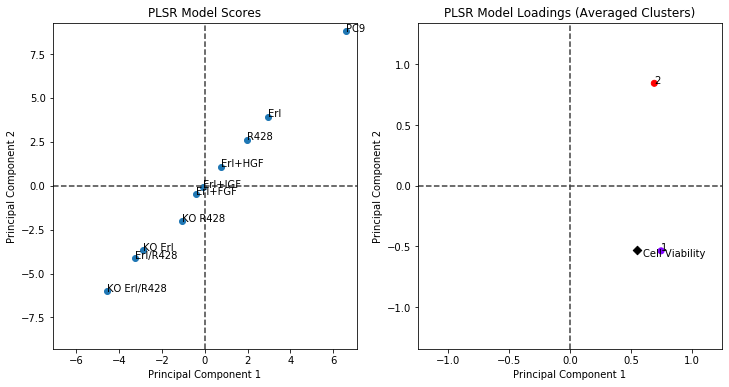

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
colors_ = cm.rainbow(np.linspace(0, 1, ncl))

# plotScoresLoadings(ax, kmeans_plsr, data, Y_cv, ncl, colors_)
plotScoresLoadings(ax, fit, centers, Y_cv, ncl, treatments)

In [14]:
clustermembers = kmeans_plsr.named_steps.kmeans.clustermembers(ABC.T)
clustermembers

,Prot_C1,abbv_C1,seqs_C1,UniprotAcc_C1,Pos_C1,r2/Std_C1,BioReps_C1,Prot_C2,abbv_C2,seqs_C2,UniprotAcc_C2,Pos_C2,r2/Std_C2,BioReps_C2
0,14-3-3 protein epsilon,Y131-p,GDYHRyLAEFA,P62258,YWHAE,1,N/A,"1-phosphatidylinositol 4,5-bisphosphate phosph...",Y783-p,RNPGFyVEANP,P19174,PLCG1,1,N/A
1,14-3-3 protein zeta/delta,Y48-p,LLSVAyKNVVG,P63104,YWHAZ,1,N/A,"10 kDa heat shock protein, mitochondrial",Y76-p,VLLPEyGGTKV,P61604,HSPE1,1,N/A
2,ARF GTPase-activating protein GIT1,Y383-p,DDQHDyDSVAS,Q9Y2X7,GIT1,1,N/A,26S proteasome non-ATPase regulatory subunit 12,Y137-p,TEGKIyVEIER,O00232,PSMD12,1,N/A
3,ATPase WRNIP1,Y500-p,AGEEHyNCISA,Q96S55,WRNIP1,1,N/A,26S proteasome non-ATPase regulatory subunit 14,Y32-p,TAEQVyISSLA,O00487,PSMD14,1,N/A
4,Abl interactor 2,Y213-p,VVPNDyVPSPT,Q9NYB9,ABI2,1,N/A,26S proteasome regulatory subunit 10B,Y207-p,SIVDKyIGESA,P62333,PSMC6,1,N/A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Vigilin,Y437-p,INRMDyVEINI,Q00341,HDLBP,1,N/A
448,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Vinculin,Y822-p,FLDSGyRILGA,P18206,VCL,3,0.12
449,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Vinculin,Y692-p,GNQAAyEHFET,P18206,VCL,3,0.14
450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WD repeat-containing protein 1,Y238-p,HDGGIyAISWS,O75083,WDR1,1,N/A


#### Cluster Averages across Conditions

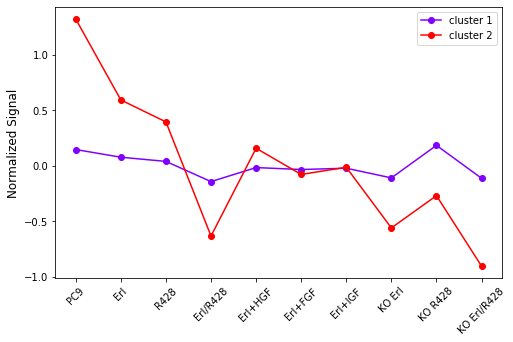

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

plotclusteraverages(ax, centers.T, treatments)